In [2]:
import os
import time
import math
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, Input, Add, Conv1D ,Conv2D, Reshape, Dropout, Permute, Activation, Multiply, concatenate, MaxPool2D, MaxPooling2D
from keras.models import Model, Sequential
!pip install scikit-plot

import scikitplot as skplt
import matplotlib.pyplot as plt
  
from keras.utils.np_utils import to_categorical   
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split , GroupShuffleSplit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
data_folder = '/gdrive/MyDrive/DNN/Inputs/' ### inputs location
score_folder = '/gdrive/MyDrive/DNN/Scores/' ### where to save scores
models_folder = '/gdrive/MyDrive/DNN/Models/' ### where to save the model

Mounted at /gdrive


In [4]:
#### Read inputs and process

BKG = pd.read_csv(data_folder + "BKG_Vars.csv")
BkgMat = BKG.values[:,7:]
YBkg = BKG.values[:,:7]
print(BKG.columns)
del BKG
Sig = pd.read_csv(data_folder+"Signal_Vars.csv")
SigMat = Sig.values[:,7:]
YSig = Sig.values[:,:7]
del Sig


X = np.concatenate([SigMat,BkgMat], axis =0 ) ### input for NN 
Y = np.concatenate([YSig,YBkg], axis =0 ) ### output for NN
#del SigMat,BkgMat,YSig,YBkg


Index(['signal', 'event_num', 'truth_pt', 'tob_pt', 'run3', 'Iso', 'Eta',
       'Et_Ratio_EM_0', 'Max_Cell_EM_0', 'Max_Cell_Ratio_EM_0', 'COM_Eta_EM_0',
       'COM_Phi_EM_0', 'Moment_Eta_EM_0', 'Moment_Phi_EM_0',
       'Est_Eta_Moment_EM_0', 'Est_Phi_Moment_EM_0', 'Et_Ratio_EM_1',
       'Max_Cell_EM_1', 'Max_Cell_Ratio_EM_1', 'COM_Eta_EM_1', 'COM_Phi_EM_1',
       'Moment_Eta_EM_1', 'Moment_Phi_EM_1', 'Est_Eta_Moment_EM_1',
       'Est_Phi_Moment_EM_1', 'Et_Ratio_EM_2', 'Max_Cell_EM_2',
       'Max_Cell_Ratio_EM_2', 'COM_Eta_EM_2', 'COM_Phi_EM_2',
       'Moment_Eta_EM_2', 'Moment_Phi_EM_2', 'Est_Eta_Moment_EM_2',
       'Est_Phi_Moment_EM_2', 'Et_Ratio_EM_3', 'Max_Cell_EM_3',
       'Max_Cell_Ratio_EM_3', 'COM_Eta_EM_3', 'COM_Phi_EM_3',
       'Moment_Eta_EM_3', 'Moment_Phi_EM_3', 'Est_Eta_Moment_EM_3',
       'Est_Phi_Moment_EM_3', 'Et_Ratio_HAD', 'Max_Cell_HAD',
       'Max_Cell_Ratio_HAD', 'COM_Eta_HAD', 'COM_Phi_HAD', 'Moment_Eta_HAD',
       'Moment_Phi_HAD', 'Est_Eta_Moment_

In [5]:
### Extract only the top 16 variables from the inputs

EtRatios = X[:,0::9] 
MaxCellRatios = X[:,2::9]
COM_Eta = X[:,3::9]
COM_Phi = X[:,4::9]
X2 = np.concatenate([EtRatios,MaxCellRatios,COM_Eta[:,[1,2,4]],COM_Phi[:,[1,2,4]]], axis =1 ) ### Using 5 Et ratios, 5 Max Cell Ratios, and COM for EM1 EM2 HAD

X2[:,10:] = (X2[:,10:] + 0.2)/0.4 ### normalize COM from [-0.2,0.2] to [0,1] range. The other variables are already normalized to [0,1]
np.max(X2, axis = 0) ### make sure the maximum is ~1 for all variables

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [6]:
ValidationFrac = 0.2
TestFrac = 0.2
train_inds, test_inds = next(GroupShuffleSplit(test_size=TestFrac, n_splits=2, random_state = int(np.random.rand()*10)).split(Y, groups=Y[:,1]))

X_train = X2[train_inds]  ### split train and test by event number, so all TOBs from the same event are kept in the same set.
X_test = X2[test_inds]

Y_train = Y[train_inds]
Y_test  = Y[test_inds]

X_train = X_train[Y_train[:,5] <900] ### remove from training any signals without truth matched TOBs. For testing these are still relevant.
Y_train = Y_train[Y_train[:,5] <900]

train_inds, test_inds = next(GroupShuffleSplit(test_size=ValidationFrac, n_splits=2, random_state = int(np.random.rand()*10)).split(Y_train, groups=Y_train[:,1]))

X_val = X_train[test_inds] ### split validation and training
X_train = X_train[train_inds]

Y_val = Y_train[test_inds]
Y_train = Y_train[train_inds]



## Define the model architecture:



In [7]:
def MainSet():  
  input = Input(shape = (16))
  Middle = Dense(64,activation = 'relu')(input)
  Middle = Dense(16,activation = 'relu')(Middle)
  output = Dense(1, activation = 'sigmoid')(Middle)
  model = Model(input, output)
  model.summary()
  return model

In [8]:
EPOCHS = 1500
BATCH_SIZE = 50000
LR = 0.01
DROPOUT = 0.3
model_name = '16_Vars' 
Y2_train = Y_train[:,0]
Y2_val = Y_val[:,0]


Weights = np.ones([Y2_train.shape[0],1])
#Weights[(np.concatenate([Y_train[:,2:3],YHighSig[:,2:3]], axis = 0) > 30000)] = 2
Weights[Y_train[:,4:5] > 30000] = 2 ### increased weights for TOBs with TOB_Pt >30 GeV


Main_Layer = MainSet()
file_name = f'{model_name}.weights.best.hdf5' 
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=models_folder + file_name, verbose = 1, save_best_only=True)
logdir = f"logs/new_fit/{model_name}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
Main_Layer.save(models_folder + f'{model_name}.h5')

adam=tf.optimizers.Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-5, amsgrad=False)

Main_Layer.compile(optimizer = adam, loss = 'mean_squared_error', metrics = ['accuracy'])
#Main_Layer.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])


Main_Layer.fit(x=X_train,y = Y2_train,  validation_data=(X_val,Y2_val) , sample_weight = Weights, epochs = EPOCHS,batch_size = BATCH_SIZE, callbacks = [tensorboard_callback, checkpointer, early_stopping_callback])
#Main_Layer.fit(x=X_train,y = Y2_train,  validation_data=(X_val,Y2_val) , epochs = EPOCHS,batch_size = BATCH_SIZE, callbacks = [tensorboard_callback, checkpointer, early_stopping_callback])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________


Epoch 1/1500
15/16 [===========================>..] - ETA: 0s - loss: 0.2268 - accuracy: 0.6424
Epoch 1: val_loss improved from inf to 0.20939, saving model to /gdrive/MyDrive/DNN/Models/Ratios_Only.weights.best.hdf5
16/16 [==============================] - 6s 37ms/step - loss: 0.2261 - accuracy: 0.6439 - val_loss: 0.2094 - val_accuracy: 0.6788
Epoch 2/1500
10/16 [=================>............] - ETA: 0s - loss: 0.2081 - accuracy: 0.6778
Epoch 2: val_loss improved from 0.20939 to 0.20507, saving model to /gdrive/MyDrive/DNN/Models/Ratios_Only.weights.best.hdf5
16/16 [==============================] - 0s 14ms/step - loss: 0.2073 - accuracy: 0.6794 - val_loss: 0.2051 - val_accuracy: 0.6834
Epoch 3/1500
10/16 [=================>............] - ETA: 0s - loss: 0.2048 - accuracy: 0.6839
Epoch 3: val_loss improved from 0.20507 to 0.20328, saving model to /gdrive/MyDrive/DNN/Models/Ratios_Only.weights.best.hdf5
16/16 [==============================] - 0s 14ms/step - loss: 0.2046 - accuracy: 

In [9]:
logits = Main_Layer.predict(X_test)

7786/7786 [==============================] - 12s 2ms/step


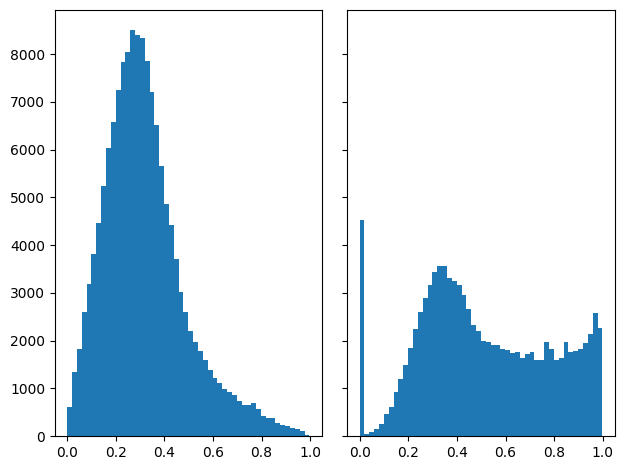

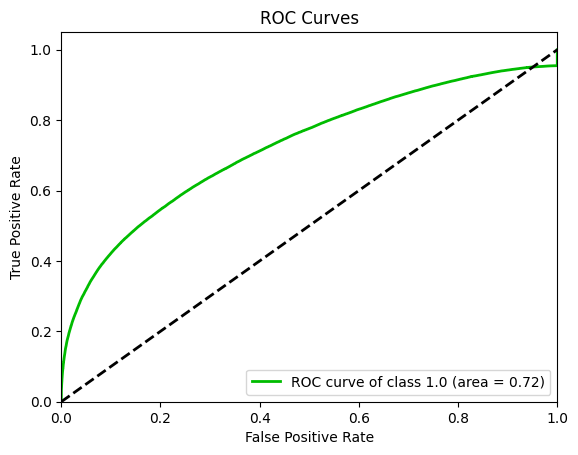

In [10]:
logits[Y_test[:,5] > 900] = 0
#logits[Y_test[:,7] > CutOff_TOB_PT] = 1
np_y = np.array(Y_test[:,0])
Pt = np.array(Y_test[:,1])
n_bins = 50
fig, axs = plt.subplots(1, 2, sharey=True, sharex = True ,tight_layout=True)
axs[0].hist(logits[np.where(np_y == 0)], bins=n_bins)
axs[1].hist(logits[np.where(np_y == 1)], bins=n_bins)
logits = np.squeeze(logits)
logits = np.expand_dims(logits,1)
Val = np.concatenate([1-logits,logits],axis = 1)
y_true = np_y # ground truth labels
y_probas = Val # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc(y_true, y_probas, plot_micro = False, plot_macro = False, classes_to_plot = 1)
plt.show()

In [11]:
c = ['signal', 'event_num', 'truth_pt', 'tob_pt', 'run3', 'Jfex_iso','seed_eta','model_score']
Result = np.concatenate([Y_test,logits], axis = 1)
Result = pd.DataFrame(Result,columns = c)
Result.to_csv(score_folder + "DNN_16_Vars.csv" ,  index = False)
